In [484]:
%matplotlib inline
from memory_profiler import memory_usage
import os
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import h5py

In [485]:
import keras
from keras.utils import np_utils
from keras.layers import Activation, Dense, Dropout, Conv2D, \
                         Flatten, MaxPooling2D, GaussianNoise, \
                         LSTM, TimeDistributed, Bidirectional, Embedding
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,ProgbarLogger
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import f1_score
import librosa
import librosa.display
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
import random
import warnings
warnings.filterwarnings('ignore')

#object serialization
import _pickle as cPickle  #python 3 change
import os  

%matplotlib inline

In [486]:

SKIP_AUDIO_RELOAD = False

In [487]:
#enable memory profiler for memory management usage %%memit 
%load_ext memory_profiler

#enable garbage collection control
import gc
gc.enable()

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [488]:
#progress tracker
from tqdm import tqdm, tqdm_notebook

In [489]:
#location of the sound files
INPUT_PATH='/Users/Bruker/prosjektH19'


TRAIN_INPUT=INPUT_PATH+'/train'
TRAIN_AUDIO_DIR=TRAIN_INPUT+'/Train'

TEST_INPUT=INPUT_PATH+'/test'
TEST_AUDIO_DIR=TEST_INPUT+'/Test'

In [490]:
def load_input_data(pd, filepath):
    # Read Data
    data = pd.read_csv(filepath)
    return data

In [491]:
# training file
TRAIN_FILE=TRAIN_INPUT+'/train.csv'
# test file
TEST_FILE=TEST_INPUT+'/test.csv'

#load info
train_input=load_input_data(pd,TRAIN_FILE)

test_input=load_input_data(pd,TEST_FILE)


In [492]:
#labels
valid_train_label = train_input[['Class']]
#x=data['label'].unique()
valid_train_label.count()

#unique classes
x = train_input.groupby('Class')['Class'].count()
x

Class
Chaffinch      91
Jack Snipe    100
Wind           98
Name: Class, dtype: int64

In [493]:
# train data size
valid_train_data = train_input[['file_ID', 'Class']] 
valid_train_data.count()



file_ID    289
Class      289
dtype: int64

In [494]:
# test data size
valid_test_data = test_input[['file_ID']] 
valid_test_data.count()

file_ID    18
dtype: int64

In [495]:
#training audio files
valid_train_data['path'] = TRAIN_AUDIO_DIR+'/' + train_input['file_ID'].astype('str')+".wav"

#test audio files
valid_test_data['path'] = TEST_AUDIO_DIR+'/' + test_input['file_ID'].astype('str') +".wav"

In [496]:
#
# set duration on audio loading to make audio content to ensure each training data have same size
# 
#fix the load audio file size
audio_play_duration=3

def load_audio_file(file_path, duration=3, sr=22050):
    #load 4 seconds audio file, sr=22050
    # To preserve the native sampling rate of the file, use sr=None
    input_length=sr*duration
    # Load an audio file as a floating point time series.
    # y : np.ndarray [shape=(n,) or (2, n)] - audio time series
    # sr : number > 0 [scalar] - sampling rate of y
    y, sr = librosa.load(file_path,sr=sr, duration=duration)
    dur = librosa.get_duration(y=y)
    #pad output if audio file less than duration
    # Use edge-padding instead of zeros
    #librosa.util.fix_length(y, 10, mode='edge')
    if (round(dur) < duration):
        offset = len(y) - round(input_length)
        print ("fixing audio length :", file_path)
        print ("input:", round(input_length), " load:", len(y) , " offset:", offset)
        y = librosa.util.fix_length(y, round(input_length))      
        ps = librosa.util.normalize(y)
    # ENDRE SR FOR Å SE OM DET KAN HJELPE
        #ps = librosa.feature.melspectrogram(y=y, sr=2000)
    return ps

In [497]:
%%time
#%%memit 
# Dataset
train_audio_data = [] 
train_object_file='saved_train_audio_data.p'

#override the reload flag if serized file doesn't exist
if not os.path.isfile(train_object_file):
    SKIP_AUDIO_RELOAD = False

#load training data
if SKIP_AUDIO_RELOAD is True:
    print ("skip re-loading TRAINING data from audio files")
else:
    print ("loading train audio data, may take more than 15 minutes. please wait!")
    for row in tqdm(valid_train_data.itertuples()):
            ps = load_audio_file(file_path=row.path, duration=3.0)
            if ps.shape != (128, 130): continue
            train_audio_data.append( (ps, row.Class) ) 
    print("Number of train samples: ", len(train_audio_data))
# this step took sometime to finish    5382
#peak memory: 1141.30 MiB, increment: 642.16 MiB
#CPU times: user 15min 41s, sys: 14min 57s, total: 30min 39s

loading train audio data, may take more than 15 minutes. please wait!


289it [00:08, 32.22it/s]


Number of train samples:  288
Wall time: 8.97 s


In [498]:
# load saved data
test_audio_data = []
test_object_file='saved_test_audio_data.p'
if SKIP_AUDIO_RELOAD is True:
    test_audio_data = cPickle.load(open(test_object_file, 'rb'))
    print ("loaded test data [%s] records from object file" % len(test_audio_data))      
else:
    cPickle.dump(test_audio_data, open(test_object_file, 'wb')) 
    print ("save loaded test data :", len(test_audio_data))

save loaded test data : 0


In [499]:
#prepare for training
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from keras.utils import to_categorical
from numpy import argmax

# get a set of unique text labels
list_labels = sorted(list(set(valid_train_data.Class.values)))
print ("unique text labels count: ",len(list_labels))
print ("labels: ",list_labels)

# integer encode
label_encoder = LabelEncoder()
label_integer_encoded = label_encoder.fit_transform(list_labels)
print("encoded labelint values", label_integer_encoded)

# one hot encode
encoded_test = to_categorical(label_integer_encoded)
inverted_test = argmax(encoded_test[0])
#print(encoded_test, inverted_test)

#map filename to label
file_to_label = {k:v for k,v in zip(valid_train_data.path.values, valid_train_data.file_ID.values)}
#print("file_to_label:", file_to_label)
# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(list_labels)}
print ("test label to int ",label_to_int["Wind"])

# map integer to text labels
int_to_label = {v:k for k,v in label_to_int.items()}
print ("int to label: ",int_to_label)

unique text labels count:  3
labels:  ['Chaffinch', 'Jack Snipe', 'Wind']
encoded labelint values [0 1 2]
test label to int  2
int to label:  {0: 'Chaffinch', 1: 'Jack Snipe', 2: 'Wind'}


In [500]:
#full dataset
dataset = train_audio_data
random.shuffle(dataset)

In [501]:
RATIO=0.7
train_cutoff= round(len(dataset) * RATIO)
train = dataset[:train_cutoff]
test = dataset[train_cutoff:]

X_train, y_train = zip(*train)
X_test, y_test = zip(*test)

# Reshape for LSTM input
X_train = np.array([x.reshape( (128, 130) ) for x in X_train])
X_test = np.array([x.reshape( (128, 130) ) for x in X_test])

print ("train ",X_train.shape, len(y_train))
print ("test ", X_test.shape, len(y_test))

train  (202, 128, 130) 202
test  (86, 128, 130) 86


In [502]:
# Apply sck-learn label text encoding to integer
label_encoder = LabelEncoder()
y_train_integer_encoded = label_encoder.fit_transform(y_train)
y_test_integer_encoded = label_encoder.fit_transform(y_test)

print('y_test:', y_test_integer_encoded)

y_test: [0 0 0 2 0 1 2 1 0 2 2 2 0 0 2 1 2 1 2 2 2 1 1 2 1 0 2 2 0 2 0 2 0 1 0 1 2
 1 1 0 2 2 2 1 1 0 0 1 2 1 1 1 2 1 1 2 0 0 1 2 0 2 2 0 2 1 1 0 1 0 1 1 2 0
 2 0 2 0 1 2 0 0 2 2 0 1]


In [503]:
# Apply Keras One-Hot encoding for classes
y_train = np.array(keras.utils.to_categorical(y_train_integer_encoded, len(list_labels)))
y_test = np.array(keras.utils.to_categorical(y_test_integer_encoded, len(list_labels)))

In [504]:
#split up test into test and validation 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3)

print ("test ",X_test.shape, len(y_test))
print ("valid ", X_val.shape, len(y_val))

test  (60, 128, 130) 60
valid  (26, 128, 130) 26


In [507]:
# Build LTSM model, input shape = (128,  130)

input_shape = X_train.shape[1:]

model = Sequential()

model.add(LSTM(16, input_shape=input_shape, return_sequences=True))  # returns a sequence of vectors of dimension 32
model.add(Activation('relu'))

model.add(LSTM(24, return_sequences=True))  
model.add(Activation('relu'))


model.add(Flatten())
model.add(Dropout(rate=0.3))

model.add(Dense(36))
model.add(Activation('relu'))
model.add(Dropout(rate=0.3))

model.add(Dense(len(list_labels)))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 128, 16)           9408      
_________________________________________________________________
activation_87 (Activation)   (None, 128, 16)           0         
_________________________________________________________________
lstm_51 (LSTM)               (None, 128, 24)           3936      
_________________________________________________________________
activation_88 (Activation)   (None, 128, 24)           0         
_________________________________________________________________
flatten_25 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 3072)              0         
_________________________________________________________________
dense_38 (Dense)             (None, 36)              

In [508]:
%%time

MAX_EPOCHS= 5
MAX_BATCH_SIZE= 23           
# learning rate reduction rate 
MAX_PATIENT= 2 

# saved model checkpoint file
best_model_file="./best_LSTM_model_trained_three.hdf5"

# callbacks
callback=[ReduceLROnPlateau(patience=MAX_PATIENT, verbose=1),
          ModelCheckpoint(filepath=best_model_file, monitor='loss', verbose=1, save_best_only=True)]

#compile
model.compile( optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

#train
print('training started.... please wait!')
history = model.fit(x=X_train, y=y_train,
                    epochs=MAX_EPOCHS,
                    batch_size=MAX_BATCH_SIZE, 
                    verbose = 0,
                    validation_data= (X_val, y_val),
                    callbacks = callback)
print('training finished')

# quick evaludate model
print('Evaluate model with test data')
score = model.evaluate(x=X_test,y=y_test)

print('test loss:', score[0])
print('test accuracy:', score[1])


training started.... please wait!

Epoch 00001: loss improved from inf to 1.07220, saving model to ./best_LSTM_model_trained_three.hdf5

Epoch 00002: loss improved from 1.07220 to 0.86798, saving model to ./best_LSTM_model_trained_three.hdf5

Epoch 00003: loss improved from 0.86798 to 0.52626, saving model to ./best_LSTM_model_trained_three.hdf5

Epoch 00004: loss improved from 0.52626 to 0.27819, saving model to ./best_LSTM_model_trained_three.hdf5

Epoch 00005: loss improved from 0.27819 to 0.13896, saving model to ./best_LSTM_model_trained_three.hdf5
training finished
Evaluate model with test data
60/60 [==============================] - ETA:  - 0s 1ms/step
test loss: 0.10202820400396982
test accuracy: 0.9833333492279053
Wall time: 18 s


In [519]:
model.save('best_model_LSTM.h5')

<Figure size 1584x720 with 0 Axes>

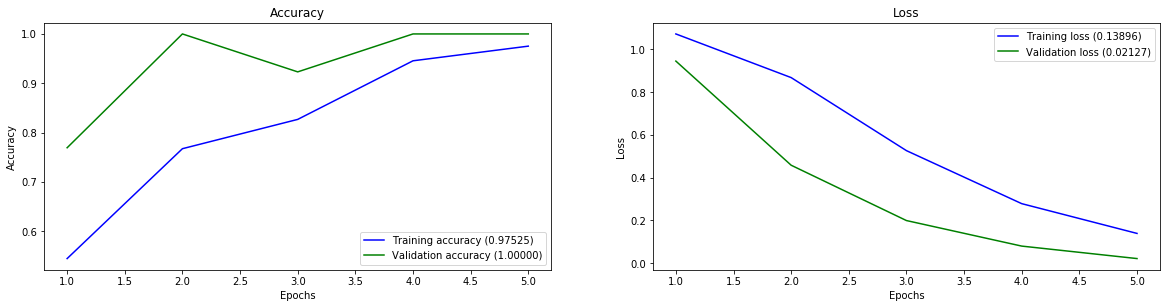

Wall time: 450 ms


In [510]:
%%time
#%%memit

import matplotlib.pyplot as plt
#Plot loss and accuracy for the training and validation set.
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    plt.figure(figsize=(22,10))
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    ## Accuracy and loss figure
    plt.figure(221, figsize=(20,10))
    # Accuracy
    plt.subplot(221, title='Accuracy')
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(222, title='Loss')
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# plot history
plot_history(history)

In [511]:
#Evaludate model use Keras reported accuracy:
score = model.evaluate(X_train, y_train, verbose=0) 
print ("model train data score       : ",round(score[1]*100) , "%")

score = model.evaluate(X_test, y_test, verbose=0) 
print ("model test data score        : ",round(score[1]*100) , "%")

score = model.evaluate(X_val, y_val, verbose=0) 
print ("model validation data score  : ", round(score[1]*100), "%")

model train data score       :  98 %
model test data score        :  98 %
model validation data score  :  100 %


In [512]:
# f1 score by using the classification report from the sklearn libary

from sklearn.metrics import classification_report
import numpy as np


y_true = np.argmax(y_test, axis = 1)
X_valid = np.expand_dims(X_test, axis = -1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = 1)
labels = [0,1,2]
target_names = list_labels 

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(60,) (60,)
              precision    recall  f1-score   support

   Chaffinch       1.00      0.96      0.98        23
  Jack Snipe       0.95      1.00      0.98        21
        Wind       1.00      1.00      1.00        16

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



In [513]:
# Prediction test
print ("Prediction with [train] data")
y_pred = model.predict_classes(X_train)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_train[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  --> match    :", len(matched))
print ("  --> miss     :", len(missed))
print ("  --> accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results where there is a miss-match
print ("---samples---")
for i in range(106):
    #print (i,"predict =", int_to_label[y_pred[i]])
    #print (i,"original=", int_to_label[argmax(y_train[i])])
    #print ("")
    if int_to_label[y_pred[i]] != int_to_label[argmax(y_train[i])]:
        print('predict', int_to_label[y_pred[i]])
        print('original', int_to_label[argmax(y_train[i])])


Prediction with [train] data
  --> match    : 198
  --> miss     : 4
  --> accuracy : 97.98 %

---samples---
predict Jack Snipe
original Chaffinch
predict Jack Snipe
original Chaffinch
predict Jack Snipe
original Wind


In [514]:
# prediction class 
print ("Prediction with [test] data")
y_pred = model.predict_classes(X_test)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_test[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(10):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_test[i])])
    print ("")

Prediction with [test] data
  |__match    : 59
  |__miss     : 1
  |__accuracy : 98.31 %

---samples---
0 predict = Wind
0 original= Wind

1 predict = Chaffinch
1 original= Chaffinch

2 predict = Jack Snipe
2 original= Jack Snipe

3 predict = Jack Snipe
3 original= Jack Snipe

4 predict = Wind
4 original= Wind

5 predict = Chaffinch
5 original= Chaffinch

6 predict = Chaffinch
6 original= Chaffinch

7 predict = Chaffinch
7 original= Chaffinch

8 predict = Jack Snipe
8 original= Jack Snipe

9 predict = Jack Snipe
9 original= Jack Snipe



In [515]:
# prediction class 
print ("Prediction with [validation] data")
y_pred = model.predict_classes(X_val)
missed=[]
matched=[]
for i in range(len(y_pred)):
    y_val_label_int = argmax(y_val[i])
    if (y_pred[i]!=y_val_label_int):
        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
    else:
        matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

print ("  |__match    :", len(matched))
print ("  |__miss     :", len(missed))
print ("  |__accuracy :", round((len(matched)-len(missed))/len(matched)*100,2), "%")
print ("")
#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(14):
    print (i,"predict =", int_to_label[y_pred[i]])
    print (i,"original=", int_to_label[argmax(y_val[i])])
    print ("")

Prediction with [validation] data
  |__match    : 26
  |__miss     : 0
  |__accuracy : 100.0 %

---samples---
0 predict = Jack Snipe
0 original= Jack Snipe

1 predict = Jack Snipe
1 original= Jack Snipe

2 predict = Wind
2 original= Wind

3 predict = Wind
3 original= Wind

4 predict = Jack Snipe
4 original= Jack Snipe

5 predict = Wind
5 original= Wind

6 predict = Wind
6 original= Wind

7 predict = Wind
7 original= Wind

8 predict = Wind
8 original= Wind

9 predict = Jack Snipe
9 original= Jack Snipe

10 predict = Wind
10 original= Wind

11 predict = Chaffinch
11 original= Chaffinch

12 predict = Jack Snipe
12 original= Jack Snipe

13 predict = Chaffinch
13 original= Chaffinch



In [516]:
## USE THE TRAINED MODEL ON RAW DATAFILES MADE FROM THE AUDIO FILES PROVIDED FROM NINA
test_audio_data = np.load('chunk.npy')
dataset = test_audio_data

In [517]:
# prediction class 
print ("Prediction with [validation] data")
y_pred = model.predict_classes(dataset)
missed=[]
matched=[]
#for i in range(len(y_pred)):
#    y_val_label_int = argmax(y_val[i])
#    if (y_pred[i]!=y_val_label_int):
#        missed.append( (y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int] ))
#    else:
#       matched.append((y_pred[i], "-", int_to_label[y_pred[i]], " - ", int_to_label[y_val_label_int]))

#print ("Value missed : \n",missed)

# show sample results
print ("---samples---")
for i in range(30):
    print (i,"predict =", int_to_label[y_pred[i]])
    print ("")

Prediction with [validation] data
---samples---
0 predict = Jack Snipe

1 predict = Jack Snipe

2 predict = Jack Snipe

3 predict = Jack Snipe

4 predict = Jack Snipe

5 predict = Jack Snipe

6 predict = Jack Snipe

7 predict = Jack Snipe

8 predict = Jack Snipe

9 predict = Jack Snipe

10 predict = Jack Snipe

11 predict = Jack Snipe

12 predict = Jack Snipe

13 predict = Jack Snipe

14 predict = Jack Snipe

15 predict = Jack Snipe

16 predict = Jack Snipe

17 predict = Jack Snipe

18 predict = Jack Snipe

19 predict = Jack Snipe

20 predict = Jack Snipe

21 predict = Jack Snipe

22 predict = Jack Snipe

23 predict = Jack Snipe

24 predict = Jack Snipe

25 predict = Jack Snipe

26 predict = Jack Snipe

27 predict = Jack Snipe

28 predict = Jack Snipe

29 predict = Jack Snipe



In [518]:
print ("---samples---")
for i in range(1000):
    print (i,"predict =", int_to_label[y_pred[i]])
    print ("")

---samples---
0 predict = Jack Snipe

1 predict = Jack Snipe

2 predict = Jack Snipe

3 predict = Jack Snipe

4 predict = Jack Snipe

5 predict = Jack Snipe

6 predict = Jack Snipe

7 predict = Jack Snipe

8 predict = Jack Snipe

9 predict = Jack Snipe

10 predict = Jack Snipe

11 predict = Jack Snipe

12 predict = Jack Snipe

13 predict = Jack Snipe

14 predict = Jack Snipe

15 predict = Jack Snipe

16 predict = Jack Snipe

17 predict = Jack Snipe

18 predict = Jack Snipe

19 predict = Jack Snipe

20 predict = Jack Snipe

21 predict = Jack Snipe

22 predict = Jack Snipe

23 predict = Jack Snipe

24 predict = Jack Snipe

25 predict = Jack Snipe

26 predict = Jack Snipe

27 predict = Jack Snipe

28 predict = Jack Snipe

29 predict = Jack Snipe

30 predict = Jack Snipe

31 predict = Wind

32 predict = Jack Snipe

33 predict = Jack Snipe

34 predict = Jack Snipe

35 predict = Jack Snipe

36 predict = Jack Snipe

37 predict = Jack Snipe

38 predict = Jack Snipe

39 predict = Jack Snipe

40

677 predict = Jack Snipe

678 predict = Jack Snipe

679 predict = Jack Snipe

680 predict = Jack Snipe

681 predict = Jack Snipe

682 predict = Jack Snipe

683 predict = Jack Snipe

684 predict = Jack Snipe

685 predict = Jack Snipe

686 predict = Jack Snipe

687 predict = Jack Snipe

688 predict = Jack Snipe

689 predict = Jack Snipe

690 predict = Jack Snipe

691 predict = Jack Snipe

692 predict = Jack Snipe

693 predict = Jack Snipe

694 predict = Jack Snipe

695 predict = Jack Snipe

696 predict = Jack Snipe

697 predict = Jack Snipe

698 predict = Jack Snipe

699 predict = Jack Snipe

700 predict = Jack Snipe

701 predict = Jack Snipe

702 predict = Jack Snipe

703 predict = Jack Snipe

704 predict = Jack Snipe

705 predict = Jack Snipe

706 predict = Jack Snipe

707 predict = Jack Snipe

708 predict = Jack Snipe

709 predict = Jack Snipe

710 predict = Jack Snipe

711 predict = Jack Snipe

712 predict = Jack Snipe

713 predict = Jack Snipe

714 predict = Jack Snipe

715 predict 